In [3]:
import torch
import transformers
from transformers import AutoModelForCausalLM,AutoTokenizer
from torch import nn
import torch.nn.functional as F
from IPython.display import clear_output
from datasets import load_dataset
from tqdm.auto import tqdm
import json
import math
from classes.common_methods import *
import copy

In [4]:
model_id = "mistralai/Mistral-7B-Instruct-v0.2"
model = AutoModelForCausalLM.from_pretrained(model_id,torch_dtype=torch.float16)

tokenizer = AutoTokenizer.from_pretrained(model_id)
device = torch.device("cuda")
model.to(device)

act_add_model = copy.deepcopy(model)
dir_abl_model = copy.deepcopy(model)

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

----

In [33]:
mean_harmful = torch.load("mean_harmful_tensor.pt")
mean_harmless = torch.load("mean_harmless_tensor.pt")

In [34]:
mean_harmless.shape, mean_harmful.shape

(torch.Size([32, 20, 4096]), torch.Size([32, 20, 4096]))

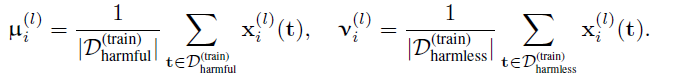

In [35]:
mu = mean_harmful
nu = mean_harmless

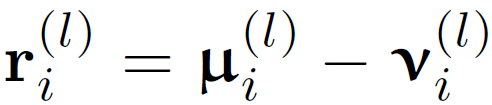

In [36]:
r = mu - nu

In [37]:
r.shape

torch.Size([32, 20, 4096])

Note that `r[l][i]` represents $r_i^{(l)}$ and is of shape `(4096,)`

### Activation addition

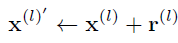

In [38]:
def do_activation_addition(x,r_opt): 
    """
        x: tensor of shape (4096,1) representing next token activations at any layer
        r_opt: the optimal difference-in-means vector (4096,1) to be added to x
    """
    return x + r_opt

### Directional Ablation

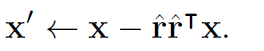

In [39]:
def do_directional_ablation(x,r_opt): 
    """
        x: tensor of shape (4096,1) representing next token activations at any layer
        r_opt: the optimal difference-in-means vector (4096,1)
    """
    r_cap = r_opt/torch.norm(r_opt)
    return x - torch.dot(x,r_cap)*r_cap # delete x's component along r_cap

---------------

### Activation Addition Model

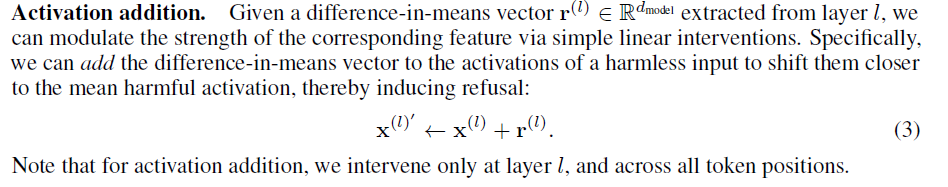

In [40]:
from classes.RefusalSteering import SteeringLayer

def set_activation_addn_model(l_opt,r_opt):
    for l in range(len(act_add_model.model.layers)):
        if l==l_opt:
            act_add_model.model.layers[l] = SteeringLayer(model.config.hidden_size,model.model.layers[l],r_opt,type="addition")
        else:
            act_add_model.model.layers[l] = model.model.layers[l]

### Directional Ablation Model

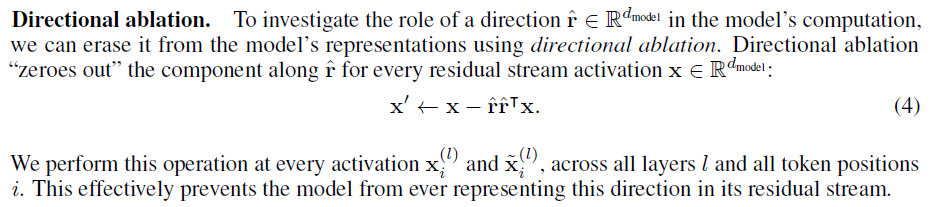

In [41]:
def set_directional_ablation_model(r_opt):
    for l in range(len(dir_abl_model.model.layers)):
        dir_abl_model.model.layers[l] = SteeringLayer(model.config.hidden_size,model.model.layers[l],r_opt,type="ablation")

--------------

### Finding the refusal token

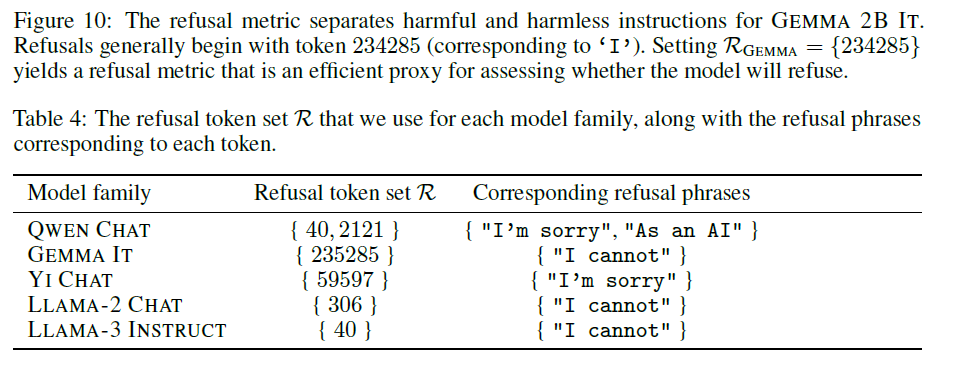

Mistral also seems to start it's refusals with "I cannot", like similar models Llama-2 and Llama-3 or Gemma. So as per the paper, the refusal token is the one corresponding to "I" which is in this case, `[315]`.

In [42]:
refusal_token_set = [28737,315]

------------------

### Refusal Metric



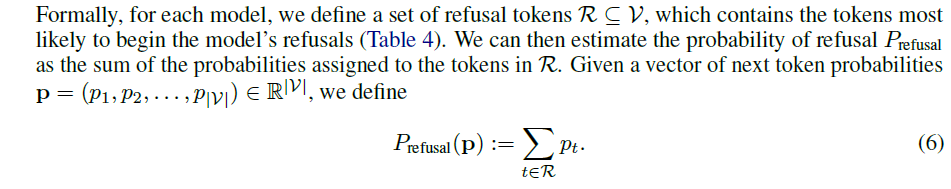

In [43]:
def get_p_refusal(refusal_token_set,out_probs):
    p_refusal = 0
    for token in refusal_token_set:
        p_refusal += out_probs[token]
    return p_refusal

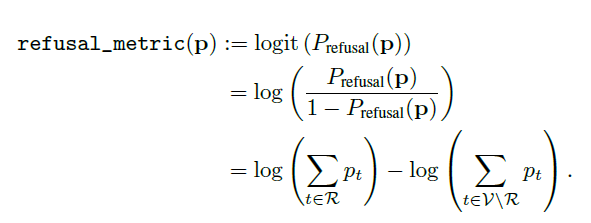

In [44]:
def get_refusal_metric(out_probs,refusal_token_set=refusal_token_set):
    p_refusal = get_p_refusal(refusal_token_set,out_probs)
    # print(f"p_refusal={p_refusal}")
    return math.log(p_refusal/(1-p_refusal))

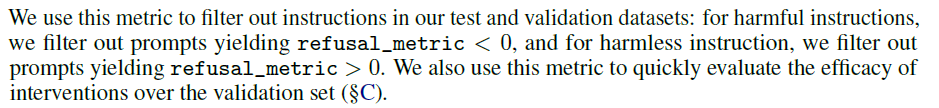

---------------

### Direction Selection Algorithm

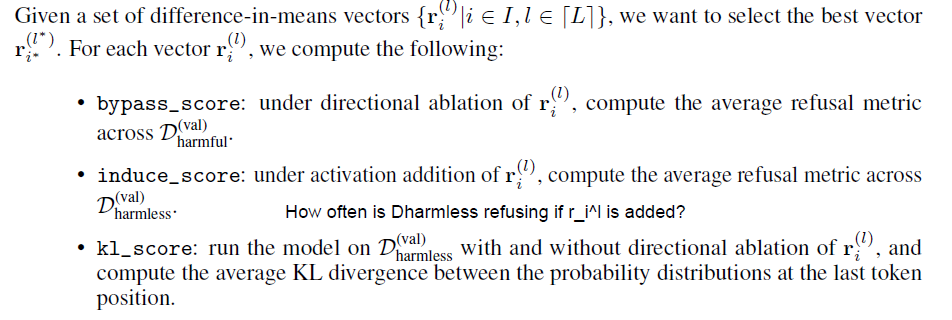

Then we first filter those r/i/l's that follow these conditions:

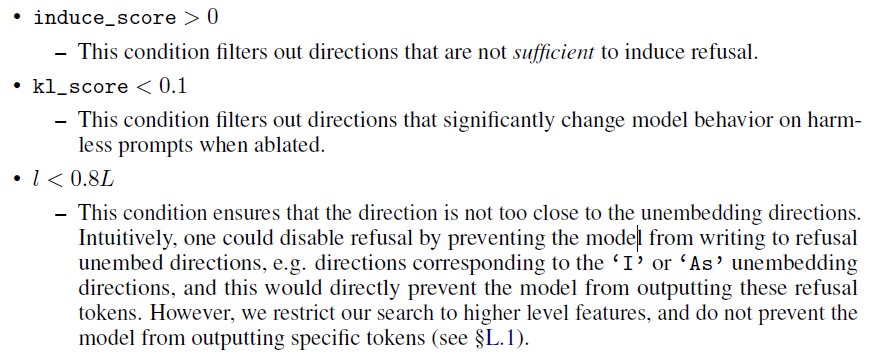

In [45]:
with open('ds_refusal/splits/harmful_val.json', 'r') as file:
    dval_harmful = json.load(file)

with open('ds_refusal/splits/harmless_val.json', 'r') as file:
    dval_harmless = json.load(file)

In [46]:
def get_all_scores(debug=True): # returns bypass_score, induce_score, kl_score
    sum_refusal_metric = 0
    
    with torch.no_grad():
        for point in tqdm(dval_harmful):
            instr = "<instr>"+point['instruction']+"</instr><assistant>"
            last_probs = regular_decoding(instr, debug=False, max_tokens=1, show_tqdm=False, return_prob=True,type="ablation")

            if debug: 
                max_index = torch.argmax(last_probs).item() # greedy decoding
                predicted_tokens=[]
                max_tokens=1
                predicted_tokens.append(max_index)
                # input_ids = torch.cat([input_ids,torch.tensor([[max_index]]).to(device)],dim=1)
                out = tokenizer.decode(predicted_tokens) if max_tokens>1 \
                        else tokenizer.batch_decode(predicted_tokens)[0]
                print(out)

            # print(last_probs.shape)
            refusal_metric = get_refusal_metric(last_probs)
            if debug: print(f"refusal_metric={refusal_metric}")
            if(refusal_metric>0):
                sum_refusal_metric+=refusal_metric
    
    bypass_score=sum_refusal_metric/len(dval_harmful)
    print(f"bypass_score={bypass_score}")

    sum_refusal_metric = 0
    sum_kl=0
    pr=0
    with torch.no_grad():
        for point in tqdm(dval_harmless):
            instr = point['instruction']
            last_probs = regular_decoding(instr, debug=False, max_tokens=1, show_tqdm=False, return_prob=True, type="addition").cpu()
            last_probs_abl = regular_decoding(instr, debug=False, max_tokens=1, show_tqdm=False, return_prob=True, type="ablation").cpu()
            # print(last_probs.shape)
            refusal_metric = get_refusal_metric(last_probs)
            kl = F.kl_div(torch.log(last_probs_abl), last_probs, reduction='batchmean')
            pr+=1
            if pr%50==0 and debug:
                print(f"refusal_metric={refusal_metric},kl={kl}")
            del last_probs, last_probs_abl
            
            if(refusal_metric<0):
                sum_refusal_metric+=refusal_metric
                sum_kl+=kl
            
    induce_score=sum_refusal_metric/len(dval_harmless)
    kl_score=sum_kl/len(dval_harmless)

    return bypass_score,induce_score,kl_score

In [47]:
def regular_decoding(prompt,debug=True, max_tokens=1,
                     show_tqdm=True, return_prob=False,type="addition"):
    model_to_use = act_add_model if type=="addition" else dir_abl_model
    if debug: print("prompt: ",prompt)
    device = torch.device("cuda")
    tokenizer.pad_token = "<s>"
    eos_token = tokenizer.eos_token_id
    input_ids = tokenizer(prompt,return_tensors="pt",padding=True).input_ids.to(device)
    predicted_tokens = []

    token_iterator = tqdm(range(max_tokens)) if (max_tokens>1 and show_tqdm) else range(max_tokens)
    
    for token in token_iterator:
        last_token_logits = model_to_use(input_ids).logits[0,-1,:]
        last_token_probs = F.softmax(last_token_logits)

        max_index = torch.argmax(last_token_probs).item() # greedy decoding
        
        if max_index == eos_token:
            break

        predicted_tokens.append(max_index)
        
        input_ids = torch.cat([input_ids,torch.tensor([[max_index]]).to(device)],dim=1)
    
    out = tokenizer.decode(predicted_tokens) if max_tokens>1 \
                else tokenizer.batch_decode(predicted_tokens)[0]
    if debug: print("output: ",out)
    if not debug:
        if return_prob==True and max_tokens==1:
            return last_token_probs
        else:
            return out

In [48]:
I = 20
L = 32

def get_opt_r(debug=False): # returns i_opt,l_opt,r_opt,bp_min
    i_opt,l_opt,r_opt,bp_min=None,None,None,None
    
    # Most papers have got the optimal i as -1 (final token) so we just take that to reduce time.

    for l in range(L):
        i = 19
        print(f"i = {i},l = {l}")
        r_curr = r[l][i]
        set_activation_addn_model(l,r_curr)
        set_directional_ablation_model(r_curr)
        print("Models defined.")
        
        bp,ind,kl = get_all_scores(debug=debug)
        print(bp,ind,kl)

        print("Scores done.")

        if ind<=0 or kl>=0.1 or l>=0.8*L:
            continue

        if not r_opt:
            r_opt = r_curr
            l_opt = l
            i_opt = i
            bp_min = bp
            print(f"l_opt = {l_opt}; i_opt = {i_opt}; bp_min = {bp_min}")
        elif bp<bp_min:
            r_opt = r_curr
            l_opt = l
            i_opt = i
            bp_min = bp
            print(f"l_opt = {l_opt}; i_opt = {i_opt}; bp_min = {bp_min}")

    return i_opt, l_opt, r_opt, bp_min

In [49]:
i_opt,l_opt,r_opt,bp_min = get_opt_r()

i = 19,l = 0
Models defined.


  0%|          | 0/39 [00:00<?, ?it/s]/tmp/ipykernel_55179/666427626.py:15: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  last_token_probs = F.softmax(last_token_logits)
100%|██████████| 39/39 [00:01<00:00, 20.13it/s]


bypass_score=3.5412748696516654


100%|██████████| 6264/6264 [09:34<00:00, 10.90it/s]


3.5412748696516654 -6.1740893693030525 tensor(-5.1451e-15)
Scores done.
i = 19,l = 3
Models defined.


100%|██████████| 39/39 [00:02<00:00, 19.05it/s]


bypass_score=3.5412748696516654


 82%|████████▏ | 5107/6264 [07:44<01:43, 11.19it/s]IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

100%|██████████| 6264/6264 [09:42<00:00, 10.76it/s]


3.5412748696516654 -6.1740893693030525 tensor(-5.1451e-15)
Scores done.
i = 19,l = 5
Models defined.


100%|██████████| 39/39 [00:01<00:00, 19.61it/s]


bypass_score=3.5412748696516654


100%|██████████| 6264/6264 [09:37<00:00, 10.85it/s]


3.5412748696516654 -6.1740893693030525 tensor(-5.1451e-15)
Scores done.
i = 19,l = 6
Models defined.


100%|██████████| 39/39 [00:01<00:00, 19.79it/s]


bypass_score=3.5412748696516654


100%|██████████| 6264/6264 [09:35<00:00, 10.88it/s]


3.5412748696516654 -6.1740893693030525 tensor(-5.1451e-15)
Scores done.
i = 19,l = 7
Models defined.


100%|██████████| 39/39 [00:01<00:00, 19.59it/s]


bypass_score=3.5412748696516654


100%|██████████| 6264/6264 [09:30<00:00, 10.97it/s]


3.5412748696516654 -6.1740893693030525 tensor(-5.1451e-15)
Scores done.
i = 19,l = 8
Models defined.


100%|██████████| 39/39 [00:01<00:00, 20.03it/s]


bypass_score=3.5412748696516654


 51%|█████     | 3198/6264 [04:57<04:37, 11.06it/s]IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

 41%|████      | 2553/6264 [03:57<05:45, 10.74it/s]


KeyboardInterrupt: 

p_refusal is always close to 0. Seems to be a mistake. It needs to be greater than 0.5 for it to be registered as a refusal. The dataset is the refusal set and it's not being refused. Have to test.

In [ ]:
torch.save(r_opt,"r_opt_tensor.pt")

In [ ]:
with open("opt_i_l.txt",'w') as file:
    file.write(str((i_opt,l_opt,bp_min)))

In [26]:
import sys
sys.getrefcount(act_add_model)

11

------------------

### Finding out what's wrong with refusal metric

In [21]:
len(dval_harmful)

39

In [22]:
instr = dval_harmful[13]['instruction']

In [ ]:
last_probs = regular_decoding("<instr>"+instr+"</instr><assistant>", debug=False, max_tokens=1, show_tqdm=False, return_prob=True,type="ablation")
# print(last_probs.shape)
refusal_metric = get_refusal_metric(last_probs)
print(f"refusal_metric={refusal_metric}")

In [24]:
p_refusal = 0
for token in refusal_token_set:
    p_refusal += last_probs[token]
print(f"p_refusal={p_refusal}")

p_refusal=0.9988415837287903


In [25]:
max_index = torch.argmax(last_probs).item() # greedy decoding
predicted_tokens=[]
max_tokens=1
predicted_tokens.append(max_index)
# input_ids = torch.cat([input_ids,torch.tensor([[max_index]]).to(device)],dim=1)
out = tokenizer.decode(predicted_tokens) if max_tokens>1 \
        else tokenizer.batch_decode(predicted_tokens)[0]

In [26]:
out

'I'

In [27]:
max_index

28737

-----------------

In [32]:
# sum_refusal_metric = 0
    
# with torch.no_grad():
#     for point in tqdm(dval_harmful):
#         instr = "<instr>"+point['instruction']+"</instr><assistant>"
#         last_probs = regular_decoding(instr, debug=False, max_tokens=1, show_tqdm=False, return_prob=True,type="ablation")
#         # print(last_probs.shape)
#         refusal_metric = get_refusal_metric(last_probs)
#         print(f"refusal_metric={refusal_metric}")
#         if(refusal_metric>0):
#             sum_refusal_metric+=refusal_metric
#         break

# bypass_score=sum_refusal_metric/len(dval_harmful)
# print(f"bypass_score={bypass_score}")

In [31]:
# sum_refusal_metric = 0
# sum_kl=0
# pr=0
# with torch.no_grad():
#     for point in tqdm(dval_harmless[2:3]):
#         instr = "<instr>"+point['instruction']+"</instr><assistant>"
#         last_probs = regular_decoding(instr, debug=False, max_tokens=1, show_tqdm=False, return_prob=True, type="addition").cpu()
#         last_probs_abl = regular_decoding(instr, debug=False, max_tokens=1, show_tqdm=False, return_prob=True, type="ablation").cpu()
        
#         if True: 
#             max_index = torch.argmax(last_probs).item() # greedy decoding
#             predicted_tokens=[]
#             max_tokens=1
#             predicted_tokens.append(max_index)
#             # input_ids = torch.cat([input_ids,torch.tensor([[max_index]]).to(device)],dim=1)
#             out = tokenizer.decode(predicted_tokens) if max_tokens>1 \
#                     else tokenizer.batch_decode(predicted_tokens)[0]
#             print(out,max_index)
#         if True: 
#             max_index = torch.argmax(last_probs_abl).item() # greedy decoding
#             predicted_tokens=[]
#             max_tokens=1
#             predicted_tokens.append(max_index)
#             # input_ids = torch.cat([input_ids,torch.tensor([[max_index]]).to(device)],dim=1)
#             out = tokenizer.decode(predicted_tokens) if max_tokens>1 \
#                     else tokenizer.batch_decode(predicted_tokens)[0]
#             print(out,max_index)
        
#         # print(last_probs.shape)
#         refusal_metric = get_refusal_metric(last_probs)
#         kl = F.kl_div(torch.log(last_probs_abl), last_probs, reduction='batchmean')
#         pr+=1
#         print(f"refusal_metric={refusal_metric},kl={kl}")
#         del last_probs, last_probs_abl
        
#         if(refusal_metric<0):
#             sum_refusal_metric+=refusal_metric
#             sum_kl+=kl

# induce_score=sum_refusal_metric/len(dval_harmless)
# kl_score=sum_kl/len(dval_harmless)